
<center><br><font size=6>Final Project</font><br>
<font size=5>Advanced Topics in Deep Learning</font><br>
<b><font size=4>Part A - EDA</font></b>
<br><br>
Authors: Ido Rappaport & Eran Tascesme 
</font></center>

**Submission Details:**
<font size=2>
<br>Ido Rappaport, ID: 322891623
<br>Eran Tascesme , ID: 205708720 </font>


**Import libraries**

In [235]:
import os
import re
import collections
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
import networkx as nx
import emoji

# Text & NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from gensim import corpora, models
from urllib.parse import urlparse


import warnings
warnings.filterwarnings('ignore')

# Ensure NLTK resources (may attempt download)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


**1. Load Data & Overview**

In [237]:
# --------------- 1. Load Data & Overview ---------------
def load_and_inspect(path=DATA_PATH):
    """
    Loads dataset and prints basic info.
    """
    print("Loading dataset:", path)
    df = pd.read_csv(path, encoding='latin1')
    print("Columns:", df.columns.tolist())
    print("Shape:", df.shape)
    print("Sample rows:")
    display(df.head())

    print("\n--- Missingness per column ---")
    missing = df.isnull().sum().sort_values(ascending=False)
    display(missing)

    
    return df


# Configuration 
DATA_PATH = "Corona_NLP_train.csv" 

# 1. Load data
df = load_and_inspect(DATA_PATH)

Loading dataset: Corona_NLP_train.csv
Columns: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']
Shape: (41157, 6)
Sample rows:


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative



--- Missingness per column ---


Location         8590
UserName            0
ScreenName          0
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

The data set contains 6 columns, so only the location column has missing values. We can conclude that the column most related to the course is 'OriginalTweet', but before we explore it, we will examine the whether the other columns have an effect on 'Sentiment'

**UserName and ScreenName Exploration**

In [240]:
# Function to check for duplicates
def check_uniqueness(column):
    num_unique = column.nunique()
    total_count = column.count()
    if num_unique < total_count:
        return "has duplicates"
    else:
        return "all values are unique"

# Check the 'UserName' column
user_name_result = check_uniqueness(df['UserName'])

# Check the 'ScreenName' column
screen_name_result = check_uniqueness(df['ScreenName'])

print(f"The 'UserName' column {user_name_result}.")
print(f"The 'ScreenName' column {screen_name_result}.")

The 'UserName' column all values are unique.
The 'ScreenName' column all values are unique.


There are no duplicates values, so it can be concluded that there is no influence between these columns and 'Sentiment', meaning they can be ignored.

**TweetAt Exploration**

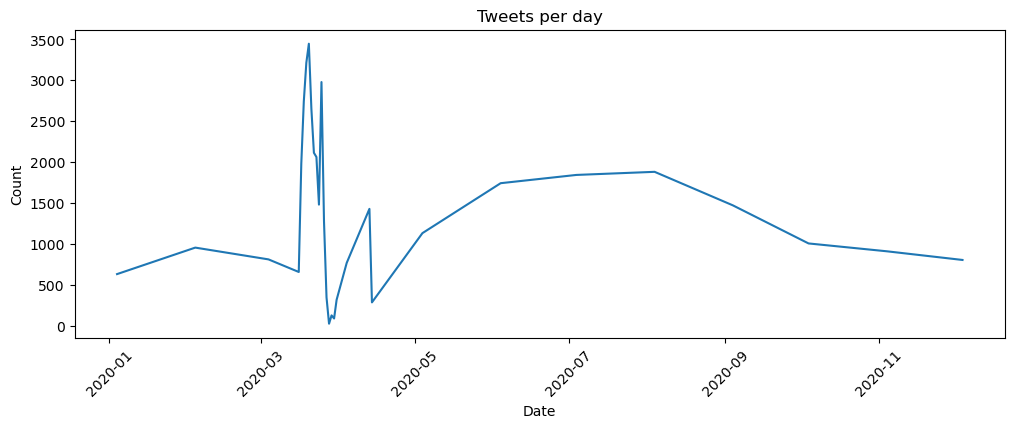

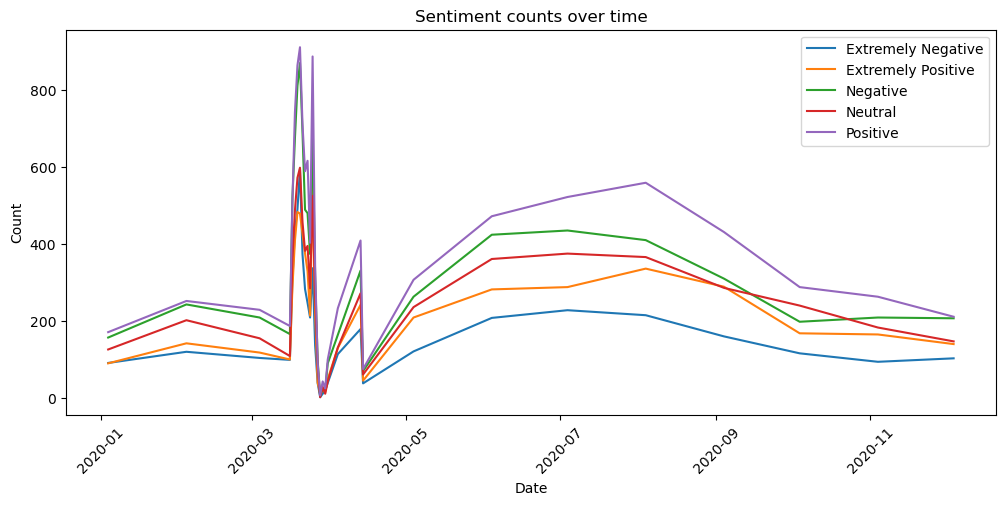

In [243]:
# --------------- Temporal Patterns ---------------
def temporal_trends(df):
    # Convert TweetAt column to datetime (try multiple formats)
    if 'TweetAt' not in df.columns:
        print("No TweetAt column found.")
        return
    # try parsing, tolerate failures
    def parse_date(x):
        for fmt in ("%d-%m-%Y %H:%M:%S", "%d-%m-%Y %H:%M", "%Y-%m-%d %H:%M:%S", "%d-%b-%Y"):
            try:
                return datetime.strptime(x, fmt)
            except Exception:
                continue
        # fallback
        try:
            return pd.to_datetime(x)
        except Exception:
            return pd.NaT
    df['TweetAt_dt'] = df['TweetAt'].astype(str).apply(parse_date)
    # Drop rows without dates
    df_time = df.dropna(subset=['TweetAt_dt']).copy()
    df_time['date'] = df_time['TweetAt_dt'].dt.date
    # daily counts
    daily = df_time.groupby('date')['OriginalTweet'].count()
    plt.figure(figsize=(12,4))
    plt.plot(daily.index, daily.values)
    plt.title("Tweets per day")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    # Sentiment over time (stacked) - compute counts per date+sentiment
    pivot = df_time.pivot_table(index='date', columns='Sentiment', values='OriginalTweet', aggfunc='count', fill_value=0)
    # Plot stacked area (each sentiment a line) - using matplotlib only
    plt.figure(figsize=(12,5))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], label=col)
    plt.legend()
    plt.title("Sentiment counts over time")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    return df_time


# 4. Temporal trends
df_time = temporal_trends(df)

Based on the Plots, it's clear that there is no correlation between a specific time and a specific sentiment. Although there are periods with more or fewer tweets, the distribution of sentiments appears very similar across all time periods. Therefore, we can assume that 'TweetAt' has no influence and can be ignored.

**Location Exploration**

Initially, we attempted to examine the relationship between Location and Sentiment by creating a graph that displayed the quantity of each sentiment versus a specific location. We found that the code was not working and showed numerous errors. We realized we needed to dive deeper and discovered that there was a lot of "irrelevant" text for the location or locations that contained various symbols. This led us to the conclusion that the data was dirty.

To address this, we checked how many data points there were for each word count and tried to see if the word count was related to a particular sentiment.

count    41157.000000
mean         1.958330
std          1.124173
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         26.000000
Name: Location_len_words, dtype: float64

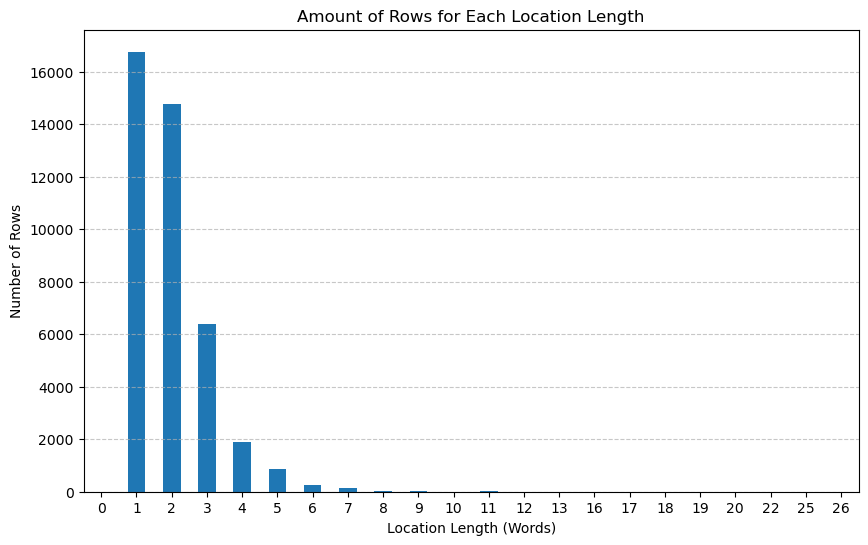

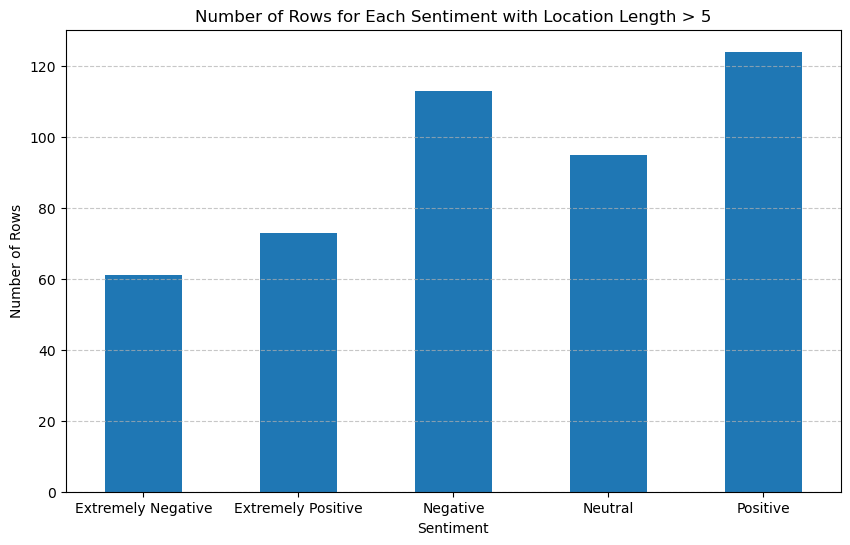

In [247]:
# Make 'Location_len_words' column that counts the words of the Location.
df['Location_len_words'] = df['Location'].astype(str).apply(lambda x: len(str(x).split()))

display(df['Location_len_words'].describe())

# Count the occurrences of each number
counts = df['Location_len_words'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Amount of Rows for Each Location Length')
plt.xlabel('Location Length (Words)')
plt.ylabel('Number of Rows')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Filter the DataFrame for rows where 'Location_len_words' is bigger than 5
filtered_df = df[df['Location_len_words'] > 5]

# Get the count of rows for each sentiment in the filtered data
sentiment_counts = filtered_df['Sentiment'].value_counts().sort_index()

# Plot the results as a bar chart
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Number of Rows for Each Sentiment with Location Length > 5')
plt.xlabel('Sentiment')
plt.ylabel('Number of Rows')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

We found that the distribution of long location names was similar to the overall data distribution, which suggests that Location length has no impact on Sentiment. However, we'll consider adding location as an additional feature in the future.

**Sentiment Exploration**


Value counts for 'Sentiment':


Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

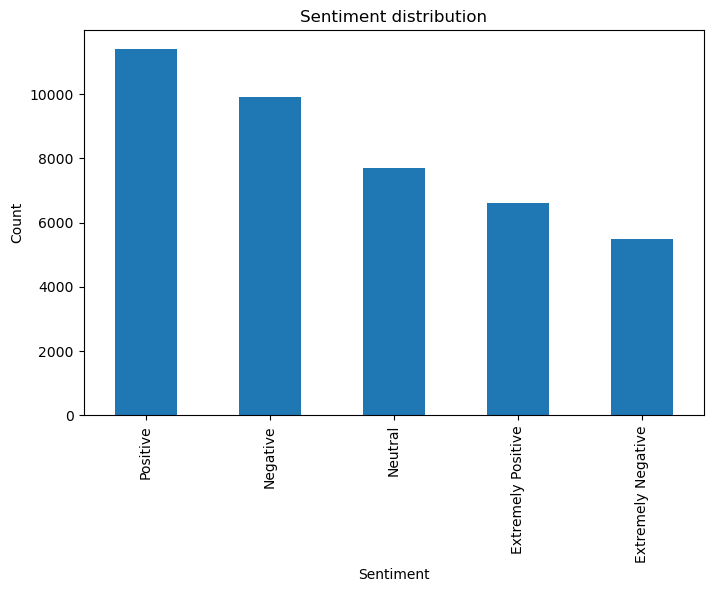

In [250]:
print(f"\nValue counts for 'Sentiment':")
display(df['Sentiment'].value_counts())

plt.figure(figsize=(8,5))
counts = df['Sentiment'].value_counts().sort_values(ascending=False)
counts.plot(kind='bar')
plt.title("Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

The dataset is unbalanced, with a significant disparity of nearly 50% between positive and extremely negative sentiments.

To address this, we will likely use text augmentation to increase the size of the minority classes. The specific augmentation techniques will be chosen based on the final model we select. Additionally, we might use a class-weighted loss function to penalize the model more heavily for misclassifying minority classes, thereby helping to mitigate the imbalance issue.

**OriginalTweet Exploration**

In [253]:
# Randomly select 5 rows
random_rows = df.sample(n=5)

# Print the 'OriginalTweet' column from the random rows
print("Randomly selected 'OriginalTweet' values:")
print("\n" + "-"*50 + "\n")
for tweet in random_rows['OriginalTweet']:
    print(f"- {tweet}")
    print("\n" + "-"*50 + "\n")



Randomly selected 'OriginalTweet' values:

--------------------------------------------------

- Due to Covid-19 govt guidelines, when requested for a  rescheduling, GOAIR exploiting the consumer by charging too much. Support is not available at all, physically visited counter to get the information.NEED HELP ASAP
@PMOIndia, @MoCA_GoI @goairlinesindia @MoHFW_INDIA @MEAIndia https://t.co/fCGNYlG5zY

--------------------------------------------------

- @MarksCanada can you please honour this card for online shopping. Due to Covid 19 I couldnÂt go in the store to use it before the expiry on Mar 28 https://t.co/eh8DWUPP83

--------------------------------------------------

- As we look at the impact of Covid-19 on business, we need to look at how marketing needs to adapt to remain relevant: research, online shopping, media, transport will all afford opportunities for innovation https://t.co/U45rweAjuS

--------------------------------------------------

- During covid 19 people are pani

We can observe a significant variety of different texts, both in terms of length and the content they contain. The dataset contains various elements like URLs, mentions, emojis, and hashtags.
1. We will begin by investigating the tweets length patterns
2. We will investigating the impact of each of the elements above on the data and make decisions accordingly.
3. We will explore certain Stopwords.

**Tweet length patterns**

We found that the number of words in the tweets ranges from 1 to 64, which is a wide range. The length of the tweets also varies significantly, from 11 to 355 characters.

Approximately 10-20% of the tweets can be defined as outliers at the ends of the distribution. However, the sentiment distribution appears stable regarding word count. The neutral sentiment is an exception, behaving opposite to the others, but its tweet count isn't an outlier compared to the rest.

We will take the following into consideration for future steps:

The ability to input tweets into a classification model

The choice of padding and tokenizer

We'll likely split the data into two sets. One will have the outliers removed to reduce noise, while the other will retain them.


Tweet length (chars) - describe:


count    41157.000000
mean       204.200160
std         68.655129
min         11.000000
25%        151.000000
50%        215.000000
75%        259.000000
max        355.000000
Name: orig_len_chars, dtype: float64


Tweet length (words) - describe:


count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: orig_len_words, dtype: float64

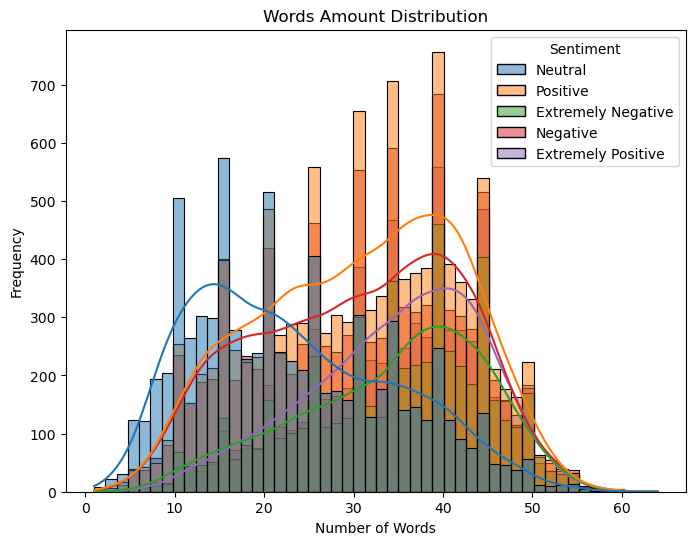

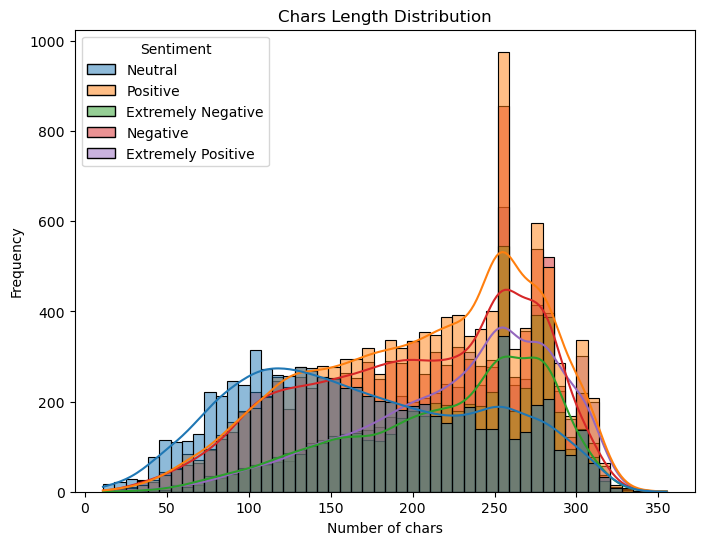

In [256]:
# Tweet length stats (raw original tweets)
df['orig_len_chars'] = df['OriginalTweet'].astype(str).apply(len)
df['orig_len_words'] = df['OriginalTweet'].astype(str).apply(lambda x: len(str(x).split()))
print("\nTweet length (chars) - describe:")
display(df['orig_len_chars'].describe())
print("\nTweet length (words) - describe:")
display(df['orig_len_words'].describe())


plt.figure(figsize=(8, 6))
sns.histplot(df, x='orig_len_words', hue='Sentiment', bins=50, kde=True, legend=True)

plt.title('Words Amount Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(8, 6))
sns.histplot(df, x='orig_len_chars', hue='Sentiment', bins=50, kde=True, legend=True)

plt.title('Chars Length Distribution')
plt.xlabel('Number of chars')
plt.ylabel('Frequency')
plt.show()


**URLs Exploration**

URLs (e.g., https://t.co) often don't carry sentiment themselves but can indicate shared resources.
We check how many tweets contain URLs and if their presence is correlated with a specific sentiment.

We find that the distribution appears similar to the regular distribution,
so we can conclude that URLs are not correlated with a specific sentiment.

Tweets containing URLs: 19822 / 41157 (48.16%)

Top domains:
 t.co              23972
t.c                   7
t.                    4
t                     3
dawn.com              1
https:                1
w                     1
digital.cv            1
images.law.com        1
buff.ly               1
Name: count, dtype: int64


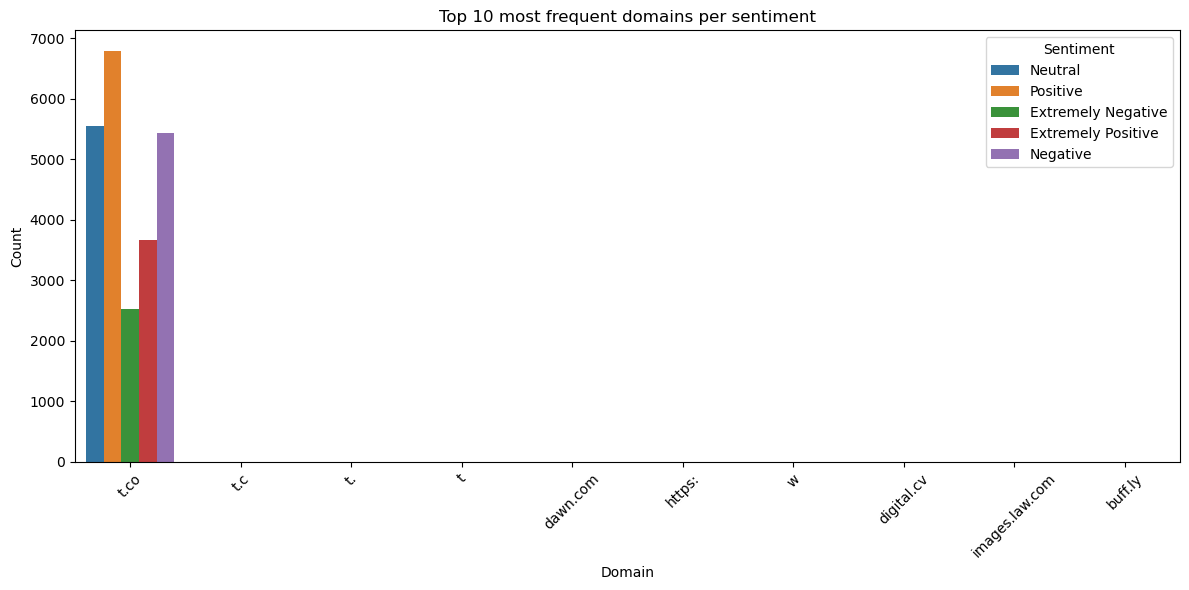

In [258]:
def explore_urls(df, text_col='OriginalTweet', sentiment_col='Sentiment', top_n=10):
    # Regex to capture URLs
    url_pattern = r'https?://\S+'
    
    # Extract URLs from tweets
    df['urls'] = df[text_col].apply(lambda x: re.findall(url_pattern, x))
    
    # Count tweets containing URLs
    tweets_with_urls = df['urls'].apply(len) > 0
    print(f"Tweets containing URLs: {tweets_with_urls.sum()} / {len(df)} "
          f"({tweets_with_urls.mean():.2%})")
    
    # Extract domains
    def extract_domain(url):
        try:
            return urlparse(url).netloc.replace("www.", "")
        except:
            return None
    
    df['domains'] = df['urls'].apply(lambda urls: [extract_domain(u) for u in urls if extract_domain(u)])
    
    # Flatten all domains to find top ones
    all_domains = [d for sublist in df['domains'] for d in sublist]
    domain_counts = pd.Series(all_domains).value_counts().head(top_n)
    print("\nTop domains:\n", domain_counts)
    
    # Filter dataframe to only include top domains
    df_exploded = df.explode('domains')
    df_exploded = df_exploded[df_exploded['domains'].isin(domain_counts.index)]
    
    # Plot: top domains per sentiment
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=df_exploded,
        x='domains',
        hue=sentiment_col,
        order=domain_counts.index
    )
    plt.title(f"Top {top_n} most frequent domains per sentiment")
    plt.xlabel("Domain")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()


explore_urls(df, text_col='OriginalTweet', sentiment_col='Sentiment', top_n=10)


**Mentions Exploration**

Mentions (e.g., @username) are common in tweets and can be a sign of a reply or a reference to a specific user.
We check the number of tweets with Mentions and if a specific user tend to be more positive or negative.

Generally, the distribution appears similar to the regular one, suggesting there's no correlation between a specific mention and a sentiment. However, there are a few exceptions. For example, YouTube has a stronger link to a neutral sentiment, while CNN is more strongly connected to a negative one.

Number of tweets with mentions: 9821
Percentage of tweets with mentions: 23.86%

Top 10 most mentioned usernames overall:
[('realDonaldTrump', 247), ('Tesco', 185), ('sainsburys', 161), ('BorisJohnson', 150), ('narendramodi', 111), ('amazon', 109), ('asda', 105), ('PMOIndia', 96), ('Morrisons', 90), ('piersmorgan', 85)]


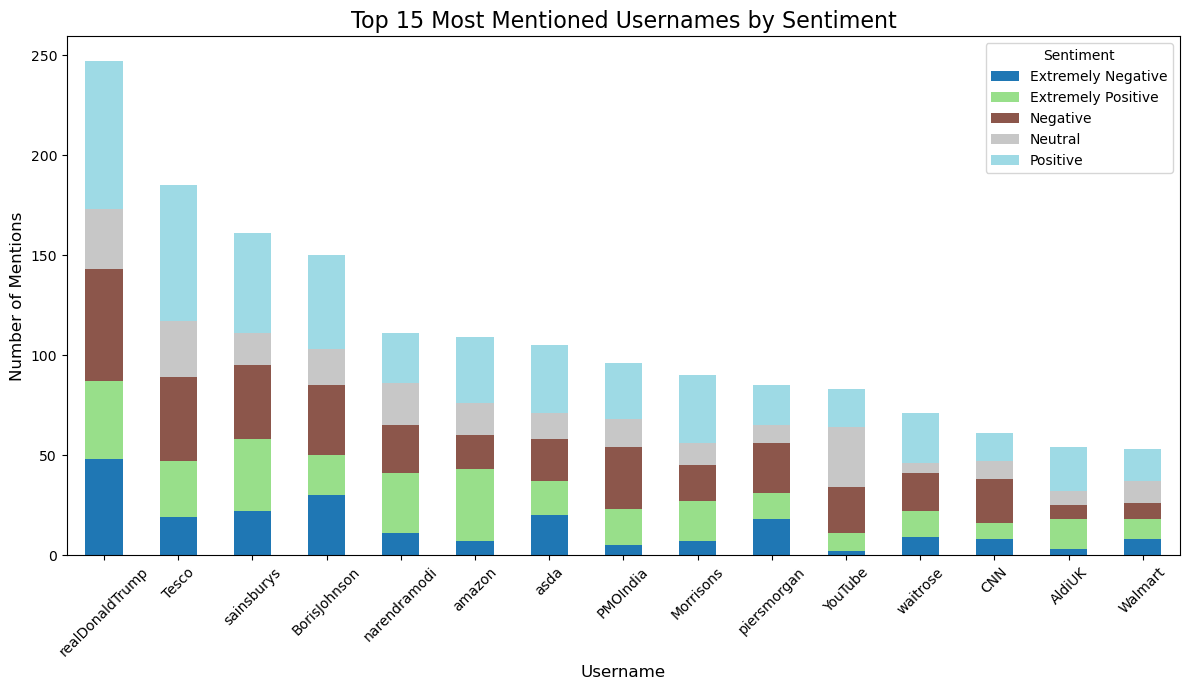

In [260]:
# Extract mentions
df['mentions'] = df['OriginalTweet'].apply(lambda x: re.findall(r'@(\w+)', x))

# Count tweets containing at least one mention
num_with_mentions = (df['mentions'].apply(len) > 0).sum()
print(f"Number of tweets with mentions: {num_with_mentions}")
print(f"Percentage of tweets with mentions: {num_with_mentions / len(df) * 100:.2f}%")

# Overall most common mentions
all_mentions = [mention for mentions_list in df['mentions'] for mention in mentions_list]
mention_counts = Counter(all_mentions)
print("\nTop 10 most mentioned usernames overall:")
print(mention_counts.most_common(10))


# Explode mentions into separate rows
mentions_df = df.explode('mentions')

# Drop rows without mentions
mentions_df = mentions_df.dropna(subset=['mentions'])

# Count total mentions
mention_counts = mentions_df['mentions'].value_counts()

# Take top 15 mentioned usernames
top_mentions = mention_counts.head(15).index

# Filter to top mentions only
top_mentions_df = mentions_df[mentions_df['mentions'].isin(top_mentions)]

# Group by mention and sentiment
mention_sentiment_counts = (
    top_mentions_df
    .groupby(['mentions', 'Sentiment'])
    .size()
    .reset_index(name='count')
)

# Pivot for plotting
mention_sentiment_pivot = mention_sentiment_counts.pivot(index='mentions', columns='Sentiment', values='count').fillna(0)

# Sort by total mentions
mention_sentiment_pivot = mention_sentiment_pivot.loc[top_mentions]

# Plot
mention_sentiment_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='tab20'
)

plt.title('Top 15 Most Mentioned Usernames by Sentiment', fontsize=16)
plt.xlabel('Username', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


**Emojis Exploration**

Emojis are powerful conveyors of sentiment in social media. 

We find that there are just 2 emojies and the total number of emojies is 70. so it doesnt influence on sentiments.

In [262]:
def extract_emojis(text):
    """
    Extracts all emojis from a given string.
    Returns a list of emojis found.
    """
    return [c for c in text if c in emoji.EMOJI_DATA]

# Create a list of all emojis found in the 'OriginalTweet' column
all_emojis = df['OriginalTweet'].apply(extract_emojis).explode().dropna().tolist()

# Calculate the total number of emojis
total_emojis = len(all_emojis)

# Get the count of each unique emoji
emoji_counts = Counter(all_emojis)

print(f"Total number of emojis in the dataset: {total_emojis}\n")
print("Top 10 most frequent emojis:")

for emoji, count in emoji_counts.most_common(10):
    print(f"- {emoji} : {count}")

Total number of emojis in the dataset: 70

Top 10 most frequent emojis:
- © : 65
- ® : 5


**Hashtags Exploration**

Hashtags (e.g., #COVID19) categorize topics and are crucial for understanding the context of a tweet.
We find that the distribution seems to follow the regular one, with no hashtags being overly correlated with a specific sentiment. However, some hashtags like #toiletpaper and #coronacrisis show a slightly different distribution.

Tweets with hashtags: 23729 / 41157


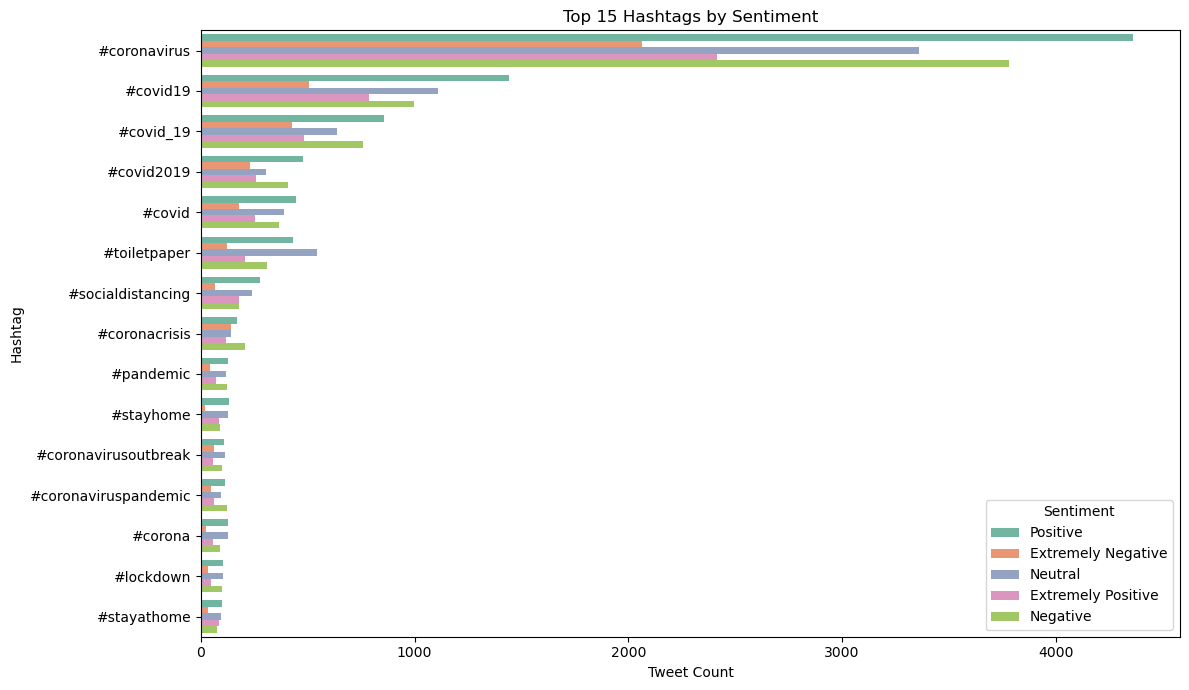

In [264]:
# Function to extract hashtags from a tweet
def extract_hashtags(text):
    return re.findall(r"#\w+", text)

# Apply extraction
df['hashtags'] = df['OriginalTweet'].apply(extract_hashtags)

# Count tweets that contain hashtags
tweets_with_hashtags = df[df['hashtags'].str.len() > 0]
print(f"Tweets with hashtags: {len(tweets_with_hashtags)} / {len(df)}")

# Flatten hashtags into a list
all_hashtags = [ht.lower() for sublist in df['hashtags'] for ht in sublist]

# Top hashtags
top_hashtags = Counter(all_hashtags).most_common(15)
top_hashtags_list = [ht for ht, _ in top_hashtags]

# Filter only rows with top hashtags
df_top_hashtags = df[df['hashtags'].apply(lambda x: any(ht.lower() in top_hashtags_list for ht in x))]

# Expand hashtags into multiple rows (one hashtag per row for sentiment grouping)
rows = []
for _, row in df_top_hashtags.iterrows():
    for ht in row['hashtags']:
        if ht.lower() in top_hashtags_list:
            rows.append({'hashtag': ht.lower(), 'Sentiment': row['Sentiment']})
df_hashtags_expanded = pd.DataFrame(rows)

# Plot sentiment counts for top hashtags
plt.figure(figsize=(12, 7))
sns.countplot(
    data=df_hashtags_expanded,
    y='hashtag',
    hue='Sentiment',
    order=[ht for ht, _ in top_hashtags],
    palette='Set2'
)
plt.title("Top 15 Hashtags by Sentiment")
plt.xlabel("Tweet Count")
plt.ylabel("Hashtag")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


**Stop Words**

First, we will check which words appear most frequently and if they have any connection to sentiment.
We will analyze the words after removing URLs, mentions, and punctuation.

As expected, most of the most frequent words were stop words like "the," "is," "on," and "if."

After removing these words, we found the most common terms are "corona", "market", "price", "grocery", and "food". These words appear most frequently across all sentiments, so we cannot assume a specific correlation between these leading words and any particular sentiment. We will decide later whether to keep or remove them.


Top 10 tokens (including stopwords):


,token,count
0,the,44881
1,to,38486
2,and,24105
3,of,21553
4,a,19489
5,in,19325
6,coronavirus,18197
7,19,15887
8,covid,15518
9,for,14063


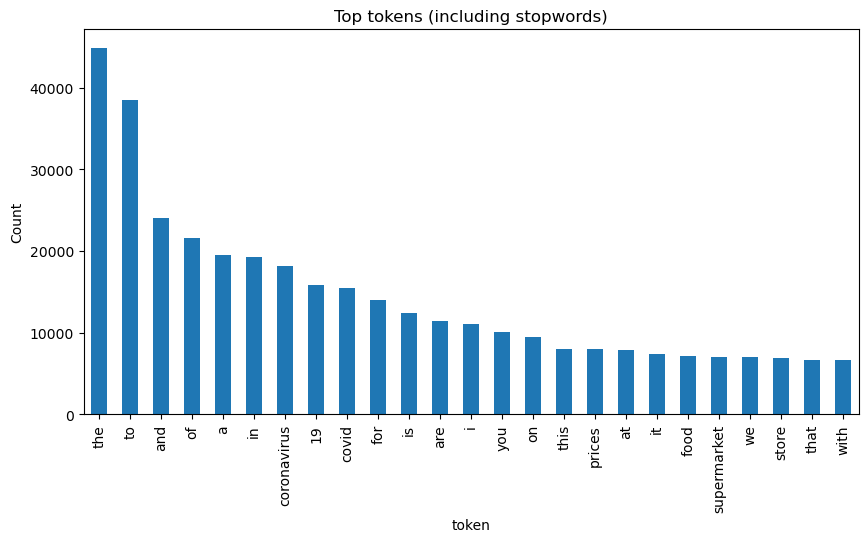

In [267]:
def text_clean(text):
    # Lowercase, remove urls, mentions, hashtags (or keep hashtag text), punctuation
    text = str(text)
    text = text.lower()
    # Replace URLs and mentions
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    # Remove punctuation except keep apostrophes
    text = re.sub(r"[^a-z0-9'\s]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# --------------- 5. Text Cleaning & Token-Level Analysis ---------------
def token_analysis(df, text_col='OriginalTweet', top_n=30):
    df['clean'] = df[text_col].astype(str).map(text_clean)
    # Tokenize and compute token stats
    df['tokens'] = df['clean'].map(lambda x: word_tokenize(x))
    df['num_tokens'] = df['tokens'].map(len)
    # vocabulary & top unigrams
    all_tokens = [t for toks in df['tokens'] for t in toks]
    freq = collections.Counter(all_tokens)
    top = freq.most_common(top_n)
    top_df = pd.DataFrame(top, columns=['token','count'])
    print(f"\nTop {10} tokens (including stopwords):")
    display(top_df.head(10))
    # Plot top tokens
    plt.figure(figsize=(10,5))
    top_words = top_df.set_index('token').head(25)
    top_words.plot(kind='bar', legend=False, ax=plt.gca())
    plt.title("Top tokens (including stopwords)")
    plt.ylabel("Count")
    plt.show()
    return df, freq


# Text cleaning & token analysis
df, freq = token_analysis(df)


Top 10 tokens after stopword removal:


,token,count
0,coronavirus,18197
1,covid,15518
2,prices,7956
3,food,7173
4,supermarket,7090
5,store,6930
6,grocery,6284
7,people,5624
8,amp,5197
9,covid19,4950


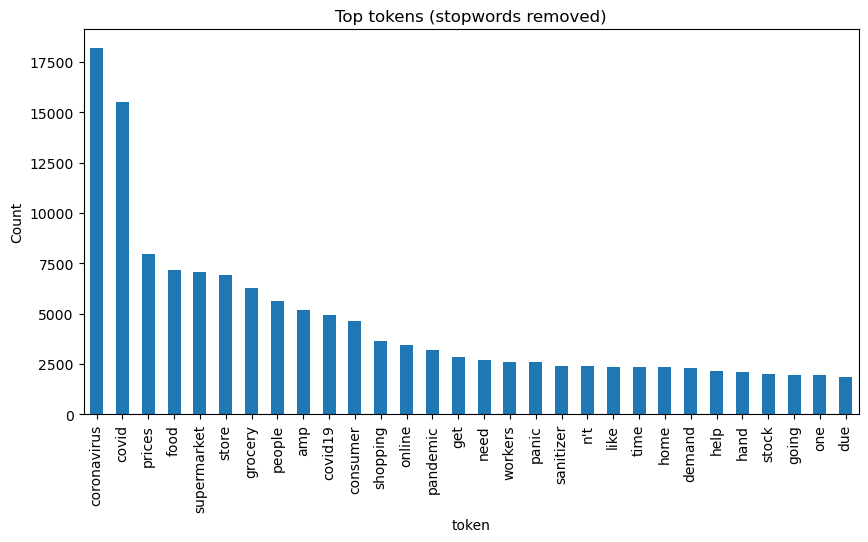

In [268]:
# --------------- Stopword Removal & Filtered Analysis ---------------
def filtered_token_analysis(df, freq, top_n=30):
    stop = set(stopwords.words('english'))
    # Optionally extend stopwords with pandemic filler words if desired
    filtered_tokens = [w for w in freq.keys() if w not in stop and len(w)>2]
    filtered_freq = {w:freq[w] for w in filtered_tokens}
    top_filtered = sorted(filtered_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]
    topf_df = pd.DataFrame(top_filtered, columns=['token','count'])
    print(f"\nTop {10} tokens after stopword removal:")
    display(topf_df.head(10))
    # Plot
    plt.figure(figsize=(10,5))
    topf_df.set_index('token').plot(kind='bar', legend=False, ax=plt.gca())
    plt.title("Top tokens (stopwords removed)")
    plt.ylabel("Count")
    plt.show()
    return topf_df


# 6. Filtered analysis
topf_df = filtered_token_analysis(df, freq)


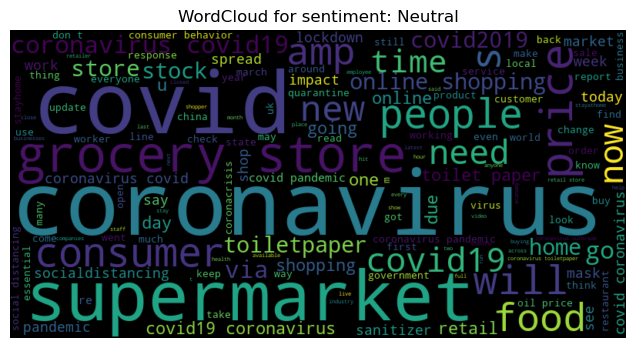

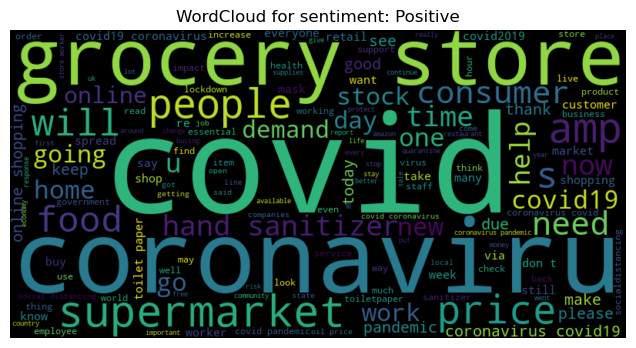

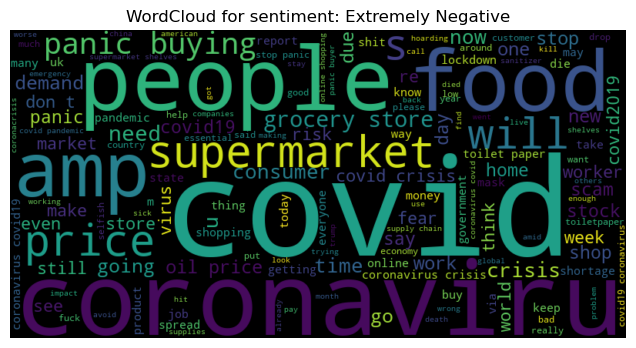

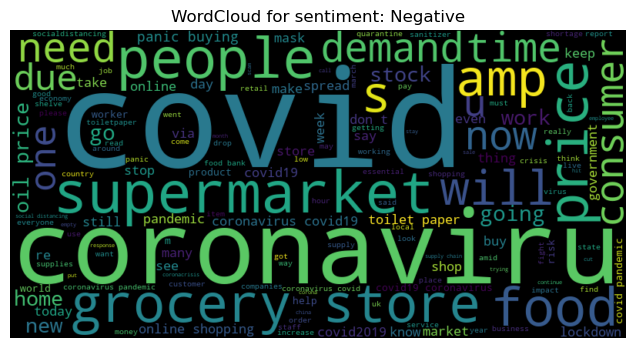

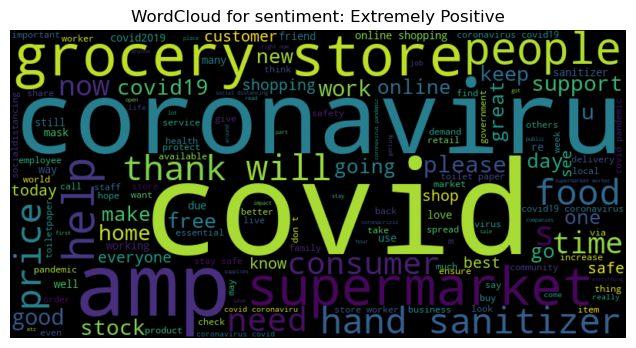

In [269]:
# --------------- Word Clouds per Sentiment ---------------
def wordclouds_by_sentiment(df, text_col='clean'):
    sentiments = df['Sentiment'].unique()
    for s in sentiments:
        text = " ".join(df.loc[df['Sentiment']==s, text_col].astype(str).values)
        wc = WordCloud(width=800, height=400, max_words=150).generate(text)
        plt.figure(figsize=(10,4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for sentiment: {s}")
        plt.show()


# 7. Wordclouds per sentiment
wordclouds_by_sentiment(df)


We concluded that there is likely no strong correlation between a specific sentiment and a particular feature. We also observed that elements such as URLs, emojis, and mentions are not concentrated within a specific sentiment. Additionally, stop words appeared most frequently and are not tied to any particular sentiment. We therefore believe these elements introduce noise into the data and can be removed.

We also found that while the data is reasonably distributed, it is imbalanced. This could lead to a bias towards a certain sentiment and harm generalizability.

Given these findings, it would be interesting to evaluate the results of the classifiers after training on data that has been cleaned of the aforementioned elements. We should also consider data augmentation for the training set.

**Examine the word count distribution after removing elements and stop words.**

We can see that there are tails with few samples, which could introduce noise.

There also appears to be a tendency for the "neutral" sentiment to be associated with a smaller number of words.

In [272]:
df['tokens_no_stop'] = df['tokens'].map(lambda x: [word for word in x if word not in stop])
df['clean_no_stop'] = df['tokens_no_stop'].map(lambda x: ' '.join(x))


Tweet length (words) - describe:


count    41157.000000
mean        18.573147
std          6.985571
min          0.000000
25%         13.000000
50%         19.000000
75%         24.000000
max         47.000000
Name: clean_len_words, dtype: float64

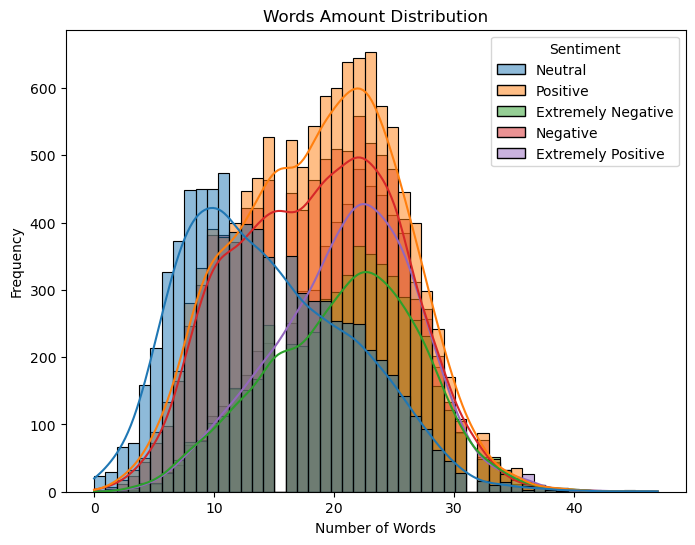

In [291]:
# Tweet length stats (raw original tweets)
df['clean_len_words'] = df['clean_no_stop'].astype(str).apply(lambda x: len(str(x).split()))
print("\nTweet length (words) - describe:")
display(df['clean_len_words'].describe())


plt.figure(figsize=(8, 6))
sns.histplot(df, x='clean_len_words', hue='Sentiment', bins=50, kde=True, legend=True)

plt.title('Words Amount Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [293]:
print(df[df['clean_len_words'] < 4][['clean_no_stop', 'Sentiment']].head(20))

                      clean_no_stop Sentiment
0                                     Neutral
16                               13   Neutral
186                                   Neutral
239              please read thread  Positive
378                    's full list   Neutral
397           coronavirusinpakistan   Neutral
414                         thought   Neutral
583                                   Neutral
602                            kind  Positive
804            mess russian cashier  Negative
904                       time step   Neutral
971            lockdown mind matter   Neutral
1121                        madness  Negative
1128                  updates visit   Neutral
1345             useful advice accc  Positive
2063  rundown supermarket covid2019   Neutral
2157                    go get food  Negative
2190                                  Neutral
2385                         3 3 63   Neutral
2917         example bastard colony  Negative


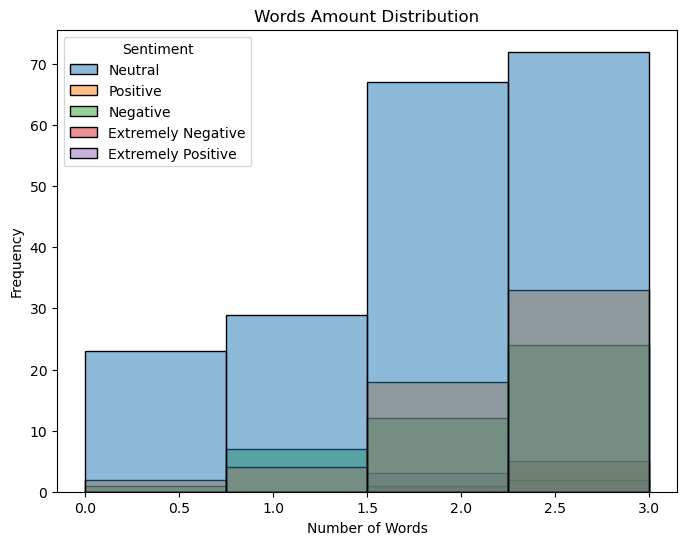

In [297]:
# Tweet length stats (raw original tweets)
plt.figure(figsize=(8, 6))
sns.histplot(df[df['clean_len_words'] < 4], x='clean_len_words', hue='Sentiment', bins=4, kde=False, legend=True)

plt.title('Words Amount Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [301]:
# Rename the columns
df_train_clean = df.rename(columns={'clean_no_stop': 'text', 'Sentiment': 'label'})
df_train_clean = df_train_clean[['text', 'label']]
df_train_clean.head()

**Cut tails**

Due to the fact that the tails may introduce noise, yet still show a preference for a specific sentiment, we will consider training the models on both the full dataset and a trimmed one without the tails.

It appears that after removing the tails, the data is distributed more smoothly, without bias.

In [312]:
df_train_cutted = df_train_clean.copy()
df_train_cutted["word_count"] = df_train_cutted["text"].apply(lambda x: len(str(x).split()))

df_train_cutted = df_train_cutted[(df_train_cutted["word_count"] >= 6) &
                          (df_train_cutted["word_count"] <= 30)]

print(f"Original size: {len(df_train_clean)}, After filtering: {len(df_train_cutted)}")

Original size: 41157, After filtering: 38868



Tweet length (words) - describe:


count    38868.000000
mean        18.456108
std          6.232855
min          6.000000
25%         13.000000
50%         19.000000
75%         23.000000
max         30.000000
Name: word_count, dtype: float64

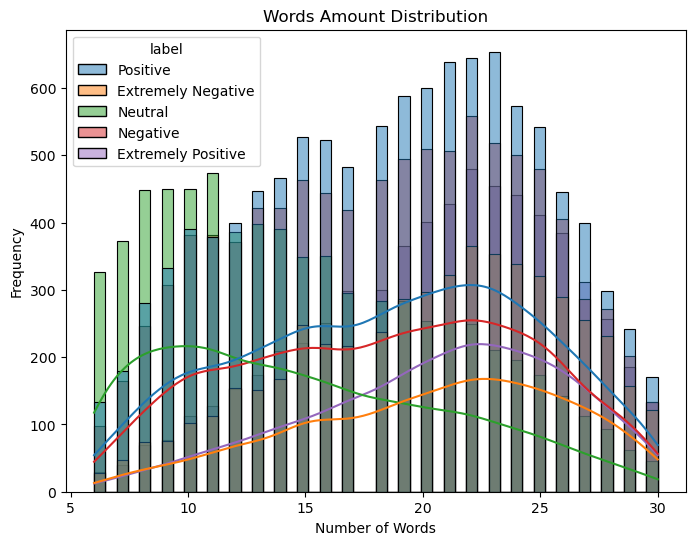

In [316]:
# Tweet length stats (raw original tweets)
print("\nTweet length (words) - describe:")
display(df_train_cutted['word_count'].describe())


plt.figure(figsize=(8, 6))
sns.histplot(df_train_cutted, x='word_count', hue='label', bins=50, kde=True, legend=True)

plt.title('Words Amount Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [318]:
# Drop the helper column and reset index
df_train_cutted = df_train_cutted.drop(columns=["word_count"]).reset_index(drop=True)
df_train_cutted.head()

,text,label
0,advice talk neighbours family exchange phone n...,Positive
1,coronavirus australia woolworths give elderly ...,Positive
2,food stock one empty please n't panic enough f...,Positive
3,ready go supermarket covid19 outbreak 'm paran...,Extremely Negative
4,news region first confirmed covid 19 case came...,Positive


<b> Processing and saving </b>

We've decided to save four types of files and split them to train/val:

1. Normal - train_dirty.csv

2. Cleaned of elements and stop words - train_clean.csv

3. Trimmed of tails - train_cutted.csv

4. With augmentation - train_balanced.csv

In [339]:
def save_train_val(df, train_name, val_name):
    sentiment_map = {
        "Negative": 0,
        "Neutral": 1,
        "Positive": 2,
        "Extremely Positive": 3,
        "Extremely Negative": 4
    }

    df["label"] = df["label"].map(sentiment_map)

    train, val = train_test_split(df, test_size=0.1, random_state=42)

    train.to_csv(train_name, index=False)
    val.to_csv(val_name, index=False)

    print(f"save {train_name} and {val_name}")
    


In [345]:
df_train_dirty = df[['OriginalTweet','label']]
df_train_dirty = df_train_dirty.rename(columns={'OriginalTweet': 'text'})
df_train_dirty.head()

save_train_val(df_train_dirty, "train_dirty.csv", "val_dirty.csv")
save_train_val(df_train_clean, "train_clean.csv", "val_clean.csv")
save_train_val(df_train_cutted, "train_cutted.csv", "val_cutted.csv")

save train_dirty.csv and val_dirty.csv
save train_clean.csv and val_clean.csv
save train_cutted.csv and val_cutted.csv


<b>Augmentation</b> (just on train set)

In [ ]:
# ---- SETTINGS ----
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

df = df_train_cutted.copy()  # DataFrame with 'text','label'

# ---- 1) Contextual Word Embedding Augmenter ----
ctx_aug = naw.ContextualWordEmbsAug(
    model_path="xlm-roberta-base",
    action="substitute",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# ---- 2) Manual Back-Translation (Hebrew <-> English) ----
def translate(texts, model_name):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    translated = model.generate(**inputs)
    return [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

def back_translate_he_en_he(text):
    # Hebrew -> English
    en_text = translate([text], "Helsinki-NLP/opus-mt-he-en")[0]
    # English -> Hebrew
    he_text = translate([en_text], "Helsinki-NLP/opus-mt-en-he")[0]
    return he_text

# ---- 3) Combine augmenters ----
def augment_text_once(text):
    out = text
    try:
        out = back_translate_he_en_he(out)
    except Exception:
        pass
    try:
        out = ctx_aug.augment(out)
        if isinstance(out, list):
            out = out[0]
    except Exception:
        pass
    return out

# ---- Balance dataset ----
counts = Counter(df["label"].tolist())
majority_label, majority_count = max(counts.items(), key=lambda kv: kv[1])

rows = []
for y, n in counts.items():
    if n >= majority_count:
        continue
    need = majority_count - n
    subset = df[df.label == y]["text"].tolist()
    base_pool = subset if len(subset) > 0 else ["טקסט חסר"]
    for _ in range(need):
        src = random.choice(base_pool)
        gen = augment_text_once(src)
        rows.append({"text": gen, "label": y})

df_balanced = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
df_balanced.to_csv("train_balanced.csv")

<b>Feeling the test data</b>

the distributio of the sentiments in the test is equaly to train.

In addition, we saved a test_clean for models that training on train_clean.


Value counts for 'Sentiment':


Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

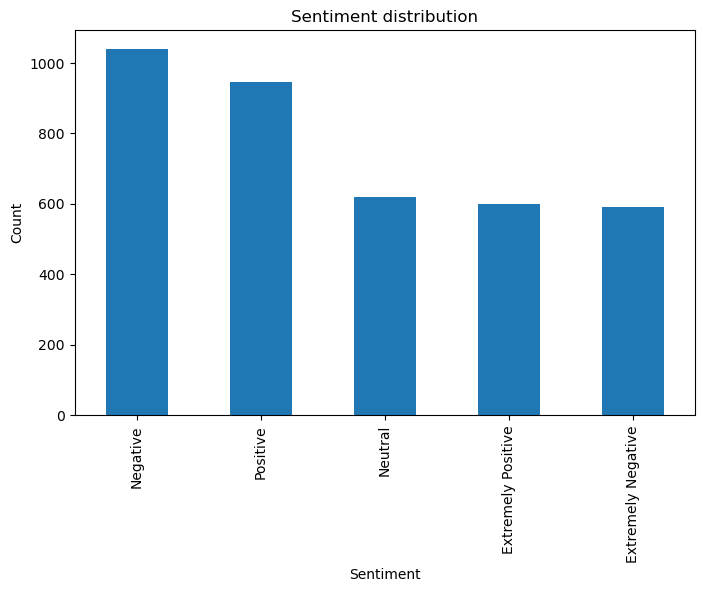

In [350]:
test_data = pd.read_csv("Corona_NLP_test.csv", encoding="ISO-8859-1")

print(f"\nValue counts for 'Sentiment':")
display(test_data['Sentiment'].value_counts())

plt.figure(figsize=(8,5))
counts = test_data['Sentiment'].value_counts().sort_values(ascending=False)
counts.plot(kind='bar')
plt.title("Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [348]:
def text_clean(text):
    # Lowercase, remove urls, mentions, hashtags (or keep hashtag text), punctuation
    text = str(text)
    text = text.lower()
    # Replace URLs and mentions
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    # Remove punctuation except keep apostrophes
    text = re.sub(r"[^a-z0-9'\s]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


test_data['clean'] = test_data['OriginalTweet'].astype(str).map(text_clean)

stop = set(stopwords.words('english'))

test_data['tokens'] = test_data['clean'].map(lambda x: word_tokenize(x))
test_data['tokens_no_stop'] = test_data['tokens'].map(lambda x: [word for word in x if word not in stop])
test_data['clean_no_stop'] = test_data['tokens_no_stop'].map(lambda x: ' '.join(x))

test_data = test_data.rename(columns={'clean_no_stop': 'text', 'Sentiment': 'label'})
test_data = test_data[['text', 'label']]

sentiment_map = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
    "Extremely Positive": 3,
    "Extremely Negative": 4
}

test_data["label"] = test_data["label"].map(sentiment_map)
test_data["label"] = test_data["label"].astype(int)
test_data = test_data[['text', 'label']]

test_data.to_csv("test_clean.csv")